In [9]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [10]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:2:1
df = pd.read_csv('../../../Data/ETH-USD.csv')
df['Close'] = df['Close']
print(df)

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df['Close'].iloc[:train_size]
test_data = df['Close'].iloc[train_size:train_size+test_size]
val_data = df['Close'].iloc[train_size+test_size:]

            Date         Open         High          Low        Close  \
0      11/9/2017   308.644989   329.451996   307.056000   320.884003   
1     11/10/2017   320.670990   324.717987   294.541992   299.252991   
2     11/11/2017   298.585999   319.453003   298.191986   314.681000   
3     11/12/2017   314.690002   319.153015   298.513000   307.907990   
4     11/13/2017   307.024994   328.415009   307.024994   316.716003   
...          ...          ...          ...          ...          ...   
2039   6/10/2023  1840.391968  1844.785645  1721.443115  1752.384766   
2040   6/11/2023  1752.527588  1776.847168  1741.110474  1753.415283   
2041   6/12/2023  1753.075439  1757.659790  1722.906372  1742.528687   
2042   6/13/2023  1742.390137  1761.955444  1727.749878  1739.037598   
2043   6/14/2023  1739.250122  1749.163208  1637.187744  1650.519287   

        Adj Close       Volume  
0      320.884003    893249984  
1      299.252991    885985984  
2      314.681000    842300992  
3  

In [11]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16151.665, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16173.795, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16159.617, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16161.765, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16173.325, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16150.505, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16154.360, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16148.659, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16154.098, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16154.811, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16148.384, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16161.645, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16159.514, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16153.532, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16150.264, Time=0.26

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [13]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[3570.10613107 3564.99486615 3569.11108322 3565.79620065 3568.46575045
 3566.31590171 3568.04722345 3566.65295095 3567.77579008 3566.87154237
 3567.59975347 3567.01330863 3567.48558591 3567.10525035 3567.41154316
 3567.16487864 3567.36352315 3567.20355024 3567.33238004 3567.22863049
 3567.31218235 3567.24489615 3567.29908324 3567.25544516 3567.29058789
 3567.26228665 3567.28507828 3567.26672367 3567.28150505 3567.26960127]


In [14]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
# RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))
# EVS
evs = explained_variance_score(test_data, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))
#MAPE
mape = mean_absolute_percentage_error(test_data, y_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The root mean squared error (RMSE) on test set: 1520.038
The explained variance score (EVS) on test set: 0.000
The mean absolute percentage error (MAPE) on test set: 0.793


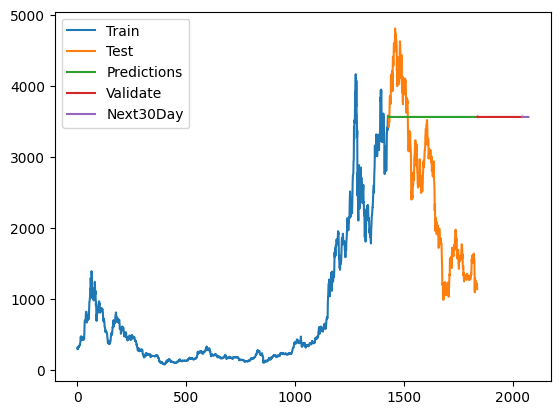

In [15]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

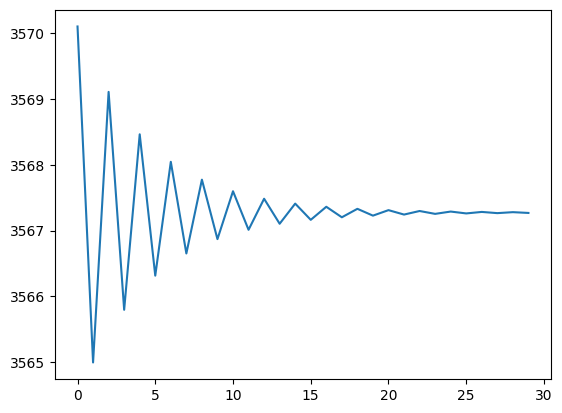

In [16]:
plt.plot(y_next_30_days)
